In [1]:
!pip -qq install git+https://github.com/PyFstat/PyFstat@python37

In [26]:
import os
import h5py # import to read hdf5
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# To create graitational waves
import pyfstat
from pyfstat.utils import get_sft_as_arrays

In [3]:
ROOT_DIR = '../input/g2net-detecting-continuous-gravitational-waves'
os.path.isdir(ROOT_DIR)

True

In [4]:
df = pd.read_csv(f"{ROOT_DIR}/train_labels.csv")
df.head()

id  target
0  001121a05       1
1  004f23b2d       1
2  00a6db666       1
3  00f36a6ac       1
4  010a387db       1

In [5]:
df.target.value_counts()

 1    400
 0    200
-1      3
Name: target, dtype: int64

> label 1 when a GW signal is present in the data.

> label 0 is when a GW signal is not present in the sample.

> label -1 is for samples where the Physicists are currently unable to determine the status.

## Read HDF5 File

In [6]:
train_files = glob(f"{ROOT_DIR}/train/*.hdf5")
train_files[:5]

['../input/g2net-detecting-continuous-gravitational-waves/train/0517ef7fe.hdf5',
 '../input/g2net-detecting-continuous-gravitational-waves/train/09531cde3.hdf5',
 '../input/g2net-detecting-continuous-gravitational-waves/train/067b3fb4b.hdf5',
 '../input/g2net-detecting-continuous-gravitational-waves/train/4f61f078b.hdf5',
 '../input/g2net-detecting-continuous-gravitational-waves/train/7c2e38128.hdf5']

In [7]:
DATA_IDX = 0

In [8]:
file = Path(train_files[DATA_IDX])
with h5py.File(file, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Top level Keys: %s" % f.keys())
    key = list(f.keys())[0]
    print("This is the name of the file \n")
    # get the object type for a_group_key: usually group or dataset
    print(f"Type of the data accessed using {key}: {type(f[key])}")
    print("The type can be either Group or Dataset. Group has more keys while we can get numpy array from Dataset directly.\n")
    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    f = f[key]
    data_keys = list(f)
    print("These are the keys for the underlying group: ", data_keys, "\n")
    # get type of each data_keys
    print(type(f[data_keys[0]])) # Group
    print(type(f[data_keys[1]])) # Group
    print(type(f[data_keys[2]])) # Dataset
    print("The underlying data type for each key are Group, Group and Dataset. We thus need to go one level deep to access the data from Group. \n")
    # H1
    h1 = f[data_keys[0]]
    h1_keys = list(h1)
    print("These are the keys for the Group accessed uisng H1 key: ", h1_keys, "\n")
    # L1
    l1 = f[data_keys[1]]
    l1_keys = list(l1)
    print("These are the keys for the Group accessed uisng L1 key: ", l1_keys, "\n")
    # frequency_Hz
    freq_hz = f[data_keys[2]]
    freq_hz = list(freq_hz)
    print("Since the type accessed using frequency_hz key was Dataset, we can get the array directly. The length of the array is: ", len(freq_hz), "\n")
    # H1 data
    h1_stft = h1["SFTs"][()]
    h1_timestamp = h1["timestamps_GPS"][()]
    print("The H1 SFTs data shape: ", h1_stft.shape)
    print("The H1 timestamp data shape: ", h1_timestamp.shape, "\n")
    # H2 data
    l1_stft = l1["SFTs"][()]
    l1_timestamp = l1["timestamps_GPS"][()]
    print("The L1 SFTs data shape: ", l1_stft.shape)
    print("The L1 timestamp data shape: ", l1_timestamp.shape, "\n")
    print("We have time on the x-axis while frequency on the y-axis. \n")
    
    print("Label: ", df.loc[DATA_IDX].target)

Top level Keys: <KeysViewHDF5 ['0517ef7fe']>
This is the name of the file 

Type of the data accessed using 0517ef7fe: <class 'h5py._hl.group.Group'>
The type can be either Group or Dataset. Group has more keys while we can get numpy array from Dataset directly.

These are the keys for the underlying group:  ['H1', 'L1', 'frequency_Hz'] 

<class 'h5py._hl.group.Group'>
<class 'h5py._hl.group.Group'>
<class 'h5py._hl.dataset.Dataset'>
The underlying data type for each key are Group, Group and Dataset. We thus need to go one level deep to access the data from Group. 

These are the keys for the Group accessed uisng H1 key:  ['SFTs', 'timestamps_GPS'] 

These are the keys for the Group accessed uisng L1 key:  ['SFTs', 'timestamps_GPS'] 

Since the type accessed using frequency_hz key was Dataset, we can get the array directly. The length of the array is:  360 

The H1 SFTs data shape:  (360, 4647)
The H1 timestamp data shape:  (4647,) 

The L1 SFTs data shape:  (360, 4719)
The L1 timestam

In [9]:
# Utility to read hdf5 file
def read_data(file: Path):
    with h5py.File(file, "r") as f:
        filename = file.stem
        f = f[filename]
        h1 = f["H1"]
        l1 = f["L1"]
        freq_hz = list(f["frequency_Hz"])
        
        h1_stft = h1["SFTs"][()]
        h1_timestamp = h1["timestamps_GPS"][()]
        # H2 data
        l1_stft = l1["SFTs"][()]
        l1_timestamp = l1["timestamps_GPS"][()]
        
        return {
            "H1": [h1_stft, h1_timestamp],
            "L1": [l1_stft, l1_timestamp],
            "freq_hz": freq_hz
        }

In [10]:
file = Path(train_files[1])
data = read_data(file)
h1_sft, h1_ts = data["H1"]
l1_sft, l1_ts = data["L1"]
freq_hz = data["freq_hz"]

Understanding shapes of the data gives a nice insight.

In [11]:
print(f"The shape of H1 SFT is: {h1_sft.shape} while that of it's time stamp is: {h1_ts.shape}")
print(f"The shape of L1 SFT is: {l1_sft.shape} while that of it's time stamp is: {l1_ts.shape}")
print(f"The shape of frequency Hz is: {np.array(freq_hz).shape}")

The shape of H1 SFT is: (360, 4573) while that of it's time stamp is: (4573,)
The shape of L1 SFT is: (360, 4504) while that of it's time stamp is: (4504,)
The shape of frequency Hz is: (360,)


> The x-axis is the time stamp. Note however that the time stamp may not be continuous. From the data description: "The SFTs are not always contiguous in time, since the interferometers are not continuously online."

> The H1 data corresponds to LIGO Hanford while L1 corresponds to LIGO Livingston.

> The frequency in Hz is measured from 0-360 Hz. Not sure if this is uniform throughtout the dataset.

> The timestamps between the two interferometers (LIGOs) are not the same.

# H1: LIGO Hanford

## Time stamp

In [12]:
h1_ts

array([1238166446, 1238168246, 1238170046, ..., 1248547917, 1248549717,
       1248551517])

> The timestamps are in UNIX epoch format. They can be converted to human readable time.

In [13]:
from datetime import datetime
print(datetime.utcfromtimestamp(h1_ts[0]).strftime('%Y-%m-%d %H:%M:%S'))

2009-03-27 15:07:26


> Thus this particular signal started recording on 27th March, 2009 at 3:07 PM GMT.

There are gaps in the timestamp but how wild is the gap?

In [14]:
gaps = []
a = h1_ts[0]
for b in h1_ts[1:]:
    gap = b-a
    a = b
    gaps.append(gap)

plt.figure(figsize=(20, 5))
plt.plot(h1_ts[1:], gaps, marker='.');

> Clearly there are a lot of gaps. Each spike is a gap in the timestamp. The height of each spike is the gap in UNIX epoch. The bold horizontal line is the gap that repeats multiple times, in this case it is 1800 UNIX epoch. Basically, the timestamp and thus STFs are not continuous reading (what a bummer?) and the gaps can be wild.

What about the timestamp of L1?

In [15]:
len(l1_ts) == len(h1_ts)

False

> The length of both the timestamps are different. That's expected since both the detectors might not be turned off at the same time.

In [16]:
l1_gaps = []
a = l1_ts[0]
for b in l1_ts[1:]:
    gap = b-a
    a = b
    l1_gaps.append(gap)
    
plt.figure(figsize=(20, 5))
plt.plot(l1_ts[1:], l1_gaps, marker='.');

> Clearly the gaps are different.

In [17]:
h1_ts[0] == l1_ts[0]

False

> The detectors are not taking measurements starting at the same time as well.

### Utilities

The following code is copied from [`tutorial_utils.py`](https://github.com/PyFstat/PyFstat/blob/master/examples/tutorials/tutorial_utils.py).

In [18]:
"""
Utils
=====

Utility functions to simplify tutorials.
"""
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import stats

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 20


def plot_real_imag_spectrograms(timestamps, frequency, fourier_data):
    "uses simple plt.pcolormesh"
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax in axs:
        ax.set(xlabel="SFT index", ylabel="Frequency [Hz]")

    time_in_days = (timestamps - timestamps[0]) / 1800

    axs[0].set_title("SFT Real part")
    c = axs[0].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.real,
        norm=colors.CenteredNorm(),
    )
    fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")

    axs[1].set_title("SFT Imaginary part")
    c = axs[1].pcolormesh(
        time_in_days,
        frequency,
        fourier_data.imag,
        norm=colors.CenteredNorm(),
    )

    fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

    return fig, axs


def plot_real_imag_spectrograms_with_gaps(timestamps, frequency, fourier_data, Tsft):

    # Fill up gaps with Nans
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)

    gap_data = [fourier_data[:, 0]]
    gap_timestamps = [timestamps[0]]

    for ind, gap in enumerate(gap_length):
        if gap > 0:
            gap_data.append(np.full_like(fourier_data[:, ind], np.nan + 1j * np.nan))
            gap_timestamps.append(timestamps[ind] + Tsft)

        gap_data.append(fourier_data[:, ind + 1])
        gap_timestamps.append(timestamps[ind + 1])

    return plot_real_imag_spectrograms(
        np.hstack(gap_timestamps), frequency, np.vstack(gap_data).T
    )


def plot_real_imag_histogram(fourier_data, theoretical_stdev=None):

    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set(xlabel="SFT value", ylabel="PDF", yscale="log")

    ax.hist(
        fourier_data.real.ravel(),
        density=True,
        bins="auto",
        histtype="step",
        lw=2,
        label="Real part",
    )
    ax.hist(
        fourier_data.imag.ravel(),
        density=True,
        bins="auto",
        histtype="step",
        lw=2,
        label="Imaginary part",
    )

    if theoretical_stdev is not None:
        x = np.linspace(-4 * theoretical_stdev, 4 * theoretical_stdev, 1000)
        y = stats.norm(scale=theoretical_stdev).pdf(x)
        ax.plot(x, y, color="black", ls="--", label="Gaussian distribution")

    ax.legend()

    return fig, ax


def plot_amplitude_phase_spectrograms(timestamps, frequency, fourier_data):
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    for ax in axs:
        ax.set(xlabel="SFT index", ylabel="Frequency [Hz]")

    time_in_days = (timestamps - timestamps[0]) / 1800

    axs[0].set_title("SFT absolute value")
    c = axs[0].pcolorfast(
        time_in_days, frequency, np.absolute(fourier_data), norm=colors.Normalize()
    )
    fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Value")

    axs[1].set_title("SFT phase")
    c = axs[1].pcolorfast(
        time_in_days, frequency, np.angle(fourier_data), norm=colors.CenteredNorm()
    )

    fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Value")

    return fig, axs

## STFT

Short time fourier transform computes the fourier transform of the signal at shorter duration of signals given by a window size. The DFT (discrete fourier transform) or FFT (fast fourier transform) are computed by taking the entire duration of the signal into consideration.

Note that the plots generated below are not considering the gaps in the timestamp and considers the data as a single continuous SFT.



In [19]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f"Filename Id: {file.stem}")

for d_ind, detector in enumerate(["H1", "L1"]):
    ax[d_ind][0].set(xlabel="Timestamps [GPS]",
                     ylabel="Frequency [Hz]",
                     title=f"{detector} - Real part")
    ax[d_ind][1].set(xlabel="Timestamps [GPS]",
                     ylabel="Frequency [Hz]",
                     title=f"{detector} - Imaginary part")

    c0 = ax[d_ind][0].pcolormesh(data[detector][1], data["freq_hz"], 
                                 data[detector][0].real)
    c1 = ax[d_ind][1].pcolormesh(data[detector][1], data["freq_hz"], 
                                 data[detector][0].imag)

    fig.colorbar(c0, ax=ax[d_ind][0])
    fig.colorbar(c1, ax=ax[d_ind][1])
plt.show()

Plotting the spectrogram by considering the gaps in SFTs gives a plot like this which is more meaningful. Note that I am providing the "Tsft" argument of this function as 1800. This is what the authors of PyFstat have recommened in the tutorials and by looking at the gaps ourself, 1800 is what appears multiple times.

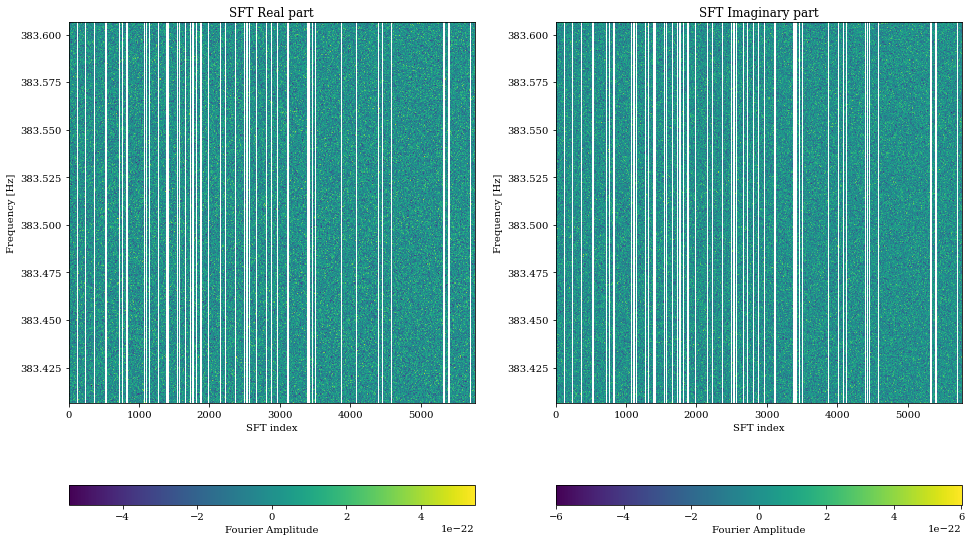

In [27]:
plot_real_imag_spectrograms_with_gaps(data[detector][1], data["freq_hz"], data[detector][0], 1800);

# Understanding By Generating

The data can better be understood if we generate the data and see how different parameters contribute to the SFTs. This section is based on the awesome tutorials provided by the host of this competition. You can find the tutorials [here](https://github.com/PyFstat/PyFstat/tree/master/examples/tutorials). The following is a distilled information in an attemp to better understand the data.

----

### TLDR;

**The SFTs generated with `h0` parameter equal to 0 have target/label as 0. The SFTs generated with `h0` parameter equal to 1, thus having SNR (signal to noise ratio) > 0 have it's target/label as 1.** The competition hosts were kind enough to clarify this [here](https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052#1973327).

The main piece of code to generate the data is `writer = pyfstat.Writer(**writer_kwargs, **signal_parameters)`. If you don't pass `**signal_parameter` you will get data corresponding to 0 and so on. You can check the `Writer` class [here](https://github.com/PyFstat/PyFstat/blob/b173b3d6e39088fa3f50110033e6c7ec2c1d6f54/pyfstat/make_sfts.py#L21).

----

The CW wave has the following properties:

* Quasi-monochromatic: "Wave in which most of the energy is confined to a single wavelength or a very narrow waveband". However, gravitational continuous waves are not completely monochromatic. ([source](http://www.idigitalphoto.com/dictionary/quasi-monochromatic))
* Long-standing: The standing waves are stationary (not a travelling wave). The disturbance does not travel in any direction. Standing waves have points of zero amplitude called nodes and points of maximum amplitude called the antinodes. 
* Produced by non-axisymmetric rapidly-spinning neutron stars
* Produce narrow-banded signals - that's why the y axis (Freq in Hz) in the spectrogram lies in a narrow band of 1-2 Hz.
* The waves are doppler-modulated due to the motion of the detector in the Solar system.

It's a common practice to use short time fourier transform to analyze these waves. These are Fourier transforms of short data segments (typically around 30 minutes or **1800 seconds**).

### Generate Gausian Noise

In [21]:
# Setup Writer
writer_kwargs = {
    "label": "single_detector_gaussian_noise",
    "outdir": "PyFstat_example_data",
    "tstart": 1238166018,  # Starting time of the observation [GPS time]
    "duration": 5 * 86400,  # Duration [seconds]
    "detectors": "H1",  # Detector to simulate, in this case LIGO Hanford
    "F0": 100.0,  # Central frequency of the band to be generated [Hz]
    "Band": 1.0,  # Frequency band-width around F0 [Hz]
    "sqrtSX": 1e-23,  # Single-sided Amplitude Spectral Density of the noise
    "Tsft": 1800,  # Fourier transform time duration
    "SFTWindowType": "tukey",  # Window function to compute short Fourier transforms
    "SFTWindowBeta": 0.01,  # Parameter associated to the window function
}
writer = pyfstat.Writer(**writer_kwargs)

# Create SFTs
writer.make_data()

Note: "As a side note, the path where the SFTs are created is stored in the sftfilepath attribute of Writer
(mind that it gets overwritten every time make_data is called!)." ([source](https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052#1976378))

In [22]:
frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)

In [23]:
h1_sft, h1_ts = fourier_data["H1"], timestamps["H1"]
print(f"The shape of H1 SFT is: {h1_sft.shape} while that of it's time stamp is: {h1_ts.shape}")
print(f"The shape of frequency Hz is: {frequency.shape}")

The shape of H1 SFT is: (1800, 240) while that of it's time stamp is: (240,)
The shape of frequency Hz is: (1800,)


Why the shape of time stamp is (240,)?

There are three time related parameters:
```
"tstart": 1238166018,  # Starting time of the observation [GPS time]
"duration": 5 * 86400,  # Duration [seconds]
"Tsft": 1800,  # Fourier transform time duration
```

In [24]:
print(f"Total duration is : {5*86400}; time segments for SFT computation: {1800}; total timestamps: {(5*86400)/1800}")

Total duration is : 432000; time segments for SFT computation: 1800; total timestamps: 240.0


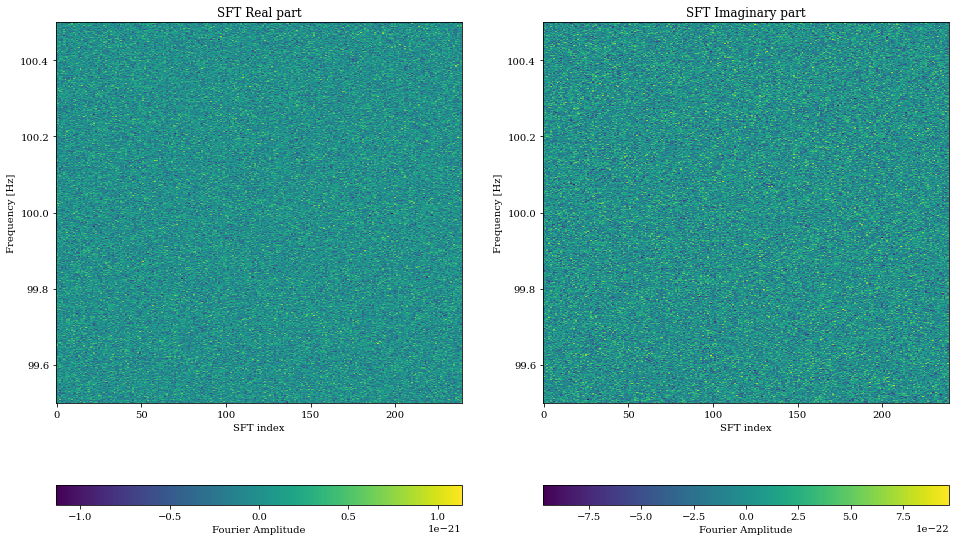

In [28]:
plot_real_imag_spectrograms(
    timestamps["H1"], frequency, fourier_data["H1"]
);

**The SNR for such a signal is 0 since there are no signal.** :P

Let's inspect the amplitude and angle of the generate SFT.

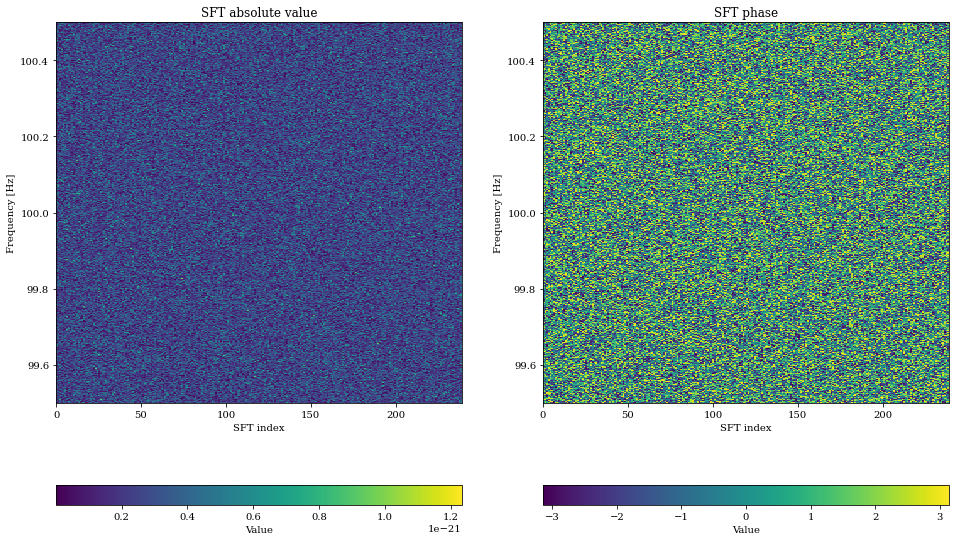

In [29]:
fig, ax = plot_amplitude_phase_spectrograms(
    timestamps["H1"], frequency, fourier_data["H1"]
);

Since it's a gaussian noise, the power (amplitude) and angle in the SFT is random.

### Generate CW Signal

The CW waves are primarily dependent on: `amplitude` and `Doppler` parameters.

- the `amplitide` parameter depends on nominal CW amplitude $h0$, the cosine of the source inclination angle with respect to the line of sight $cos(ι)$ (cosi), the polarization angle $\psi{}$ (psi) and the initial phase of the wave $\phi{}$ (phi). Depending on the emission mechanism, $h0$ can be further described using further physical quantities such as the source's frequency, ellipticity, or distance to the detector.

- the `doppler` parameter describe the relationship between the source of emmission (and it's motion) and the detectors. The parameter depends on gravitational wave frequency $f0$, spindown $f1$and sky position $\hat{n}$, which we will parametrize using the right ascension $\alpha{}$ and declination $\delta{}$ angles.


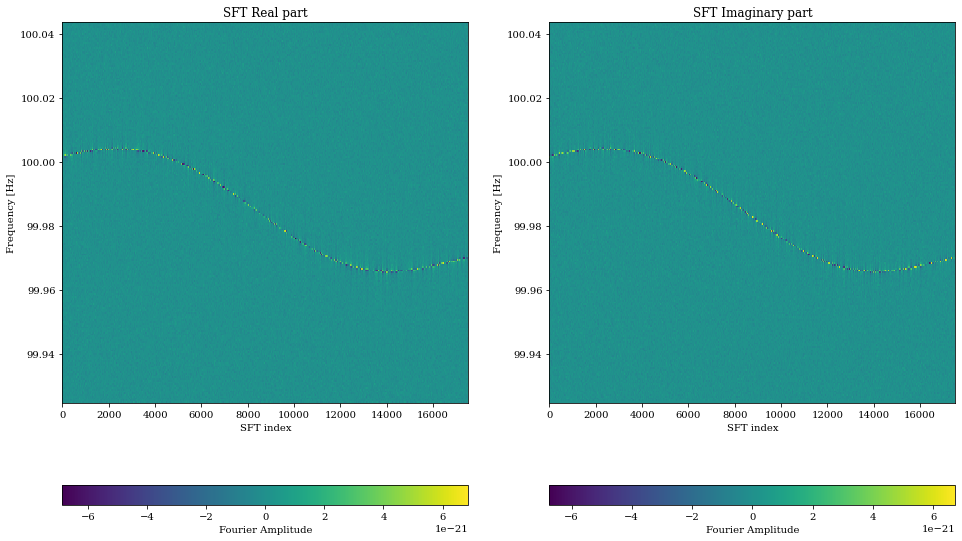

In [39]:
# The same writer params are required to generate gaussian noise.
writer_kwargs = {
    "label": "single_detector_gaussian_noise",
    "outdir": "PyFstat_example_data",
    "tstart": 1238166018,
    "duration": 365 * 86400,
    "detectors": "H1",
    "sqrtSX": 1e-23,
    "Tsft": 1800,
    "SFTWindowType": "tukey",
    "SFTWindowBeta": 0.01,
}

# These parameters determine the CW signal that we have to detect.
signal_parameters = {
    "F0": 100.0,
    "F1": -1e-9,
    "Alpha": 0.0,
    "Delta": 0.0,
    "h0": 1e-23, # this parameter in particular determines if a signal exist in the generated SFT.
    "cosi": 1,
    "psi": 0.0,
    "phi": 0.0,
    "tref": writer_kwargs["tstart"],
}

writer = pyfstat.Writer(**writer_kwargs, **signal_parameters)
writer.make_data()
frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)
plot_real_imag_spectrograms(
    timestamps["H1"], frequency, fourier_data["H1"]
);

> In this case the signal is really clear and thus SNR should be high.

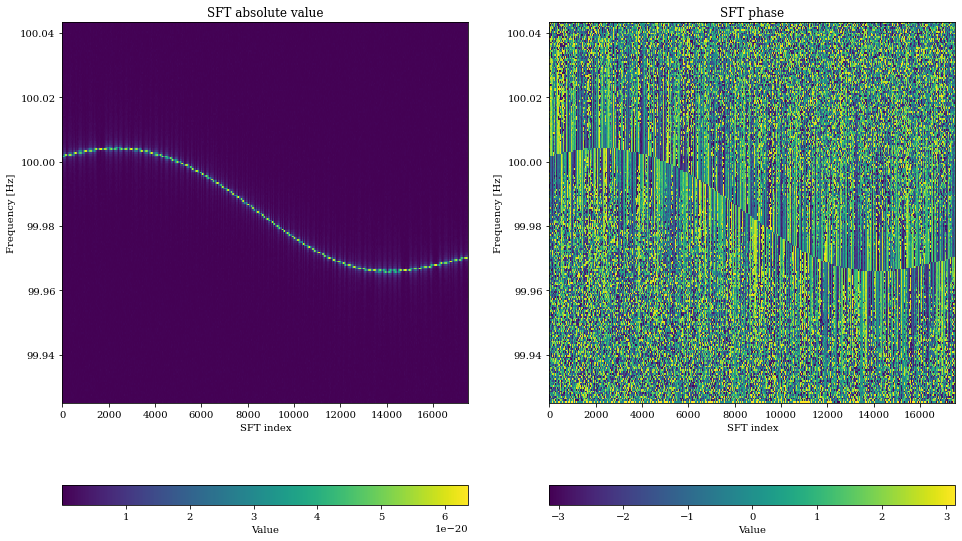

In [31]:
fig, ax = plot_amplitude_phase_spectrograms(
    timestamps["H1"], frequency, fourier_data["H1"]
);

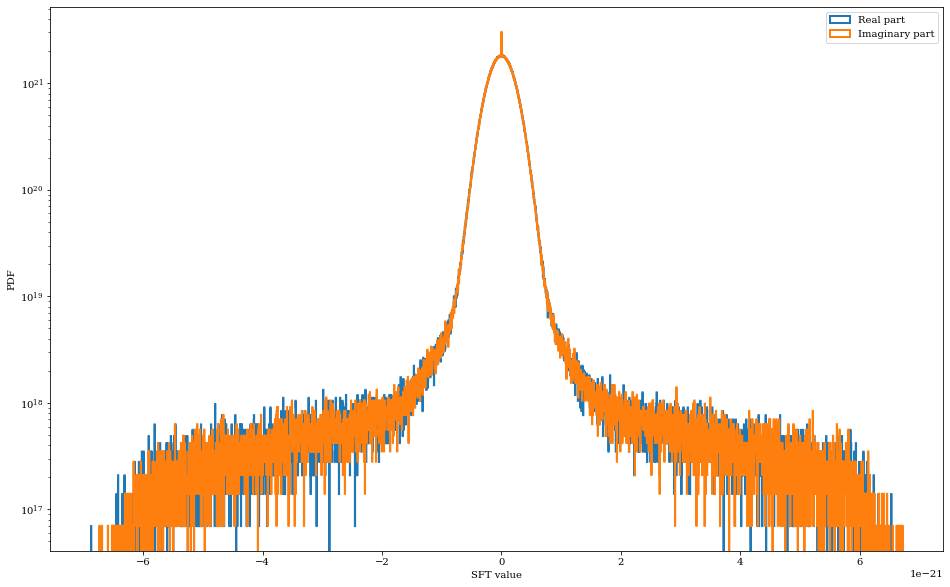

In [41]:
plot_real_imag_histogram(fourier_data["H1"]);

The power and the angle component of the generate SFT is prominent.

In [32]:
# SNR can be compute from a set of SFTs for a specific set
# of parameters as follows:
snr = pyfstat.SignalToNoiseRatio.from_sfts(
    F0=writer.F0, sftfilepath=writer.sftfilepath
)
squared_snr = snr.compute_snr2(
    Alpha=writer.Alpha, 
    Delta=writer.Delta,
    psi=writer.psi,
    phi=writer.phi, 
    h0=writer.h0,
    cosi=writer.cosi
)
sqrt_snr = np.sqrt(squared_snr)
print(f"Signal - SNR: {sqrt_snr}")

Signal - SNR: 18602.178233083847


> The data of interest (real data) should have such high SNRs (there would be no point of this competition, if signal is easily detected).

Let's talk about the possible SNR range of CW signals. As per the tutorial shared by competition hosts, "The presence of visible CW features in the spectrogram can be quantified using the so-called sensitivity depth, which is defined as the ratio between the noise and CW amplitude $D = \sqrt{Sn}/h0$. Current searches for CW signals from unknown sources are able to detect a sensitivity depth ranging between 10 $Hz^{-0.5}$ and 50 $Hz^{-0.5}$. Visual features, however, tend to disappear around a depth of 20 $Hz^{-0.5}$."

Looking at the formula, $\sqrt{Sn}$ is "sqrtSX" which in our case is `1e-23`. And we want to look at visual features where the sensitivity depth is 20 $Hz^{-0.5}$. Thus we will calculate $h0$.

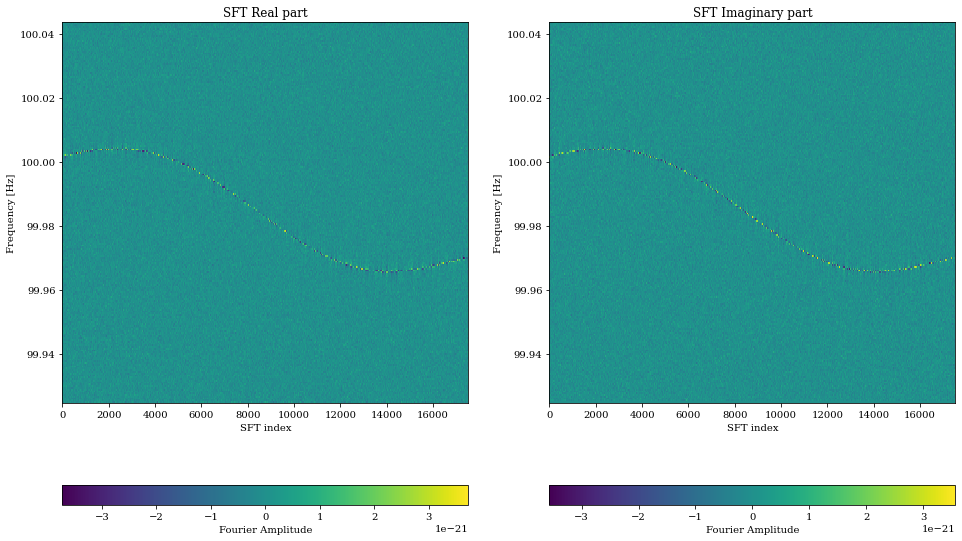

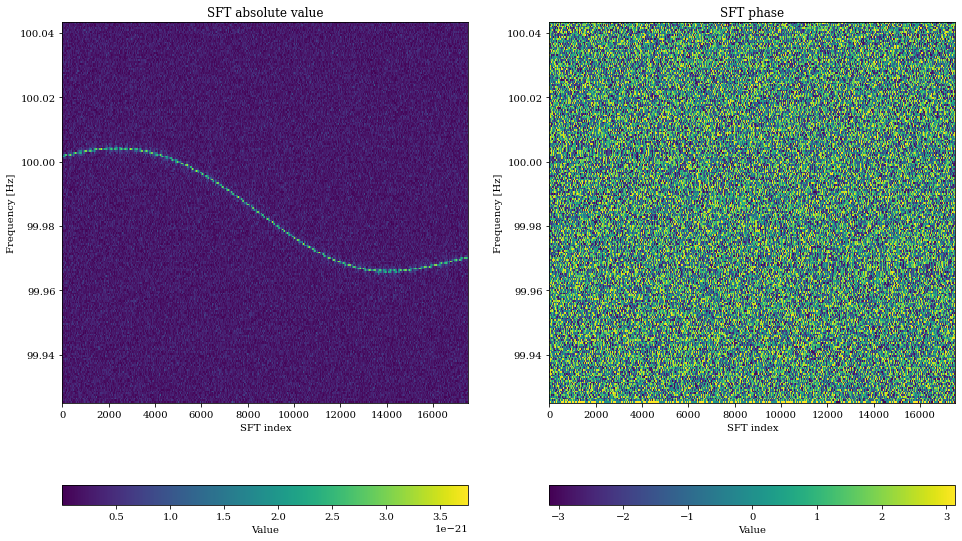

In [37]:
# CW signal at a depth of 20
signal_parameters["h0"] = writer_kwargs["sqrtSX"] / 2.0

writer = pyfstat.Writer(**writer_kwargs, **signal_parameters)

# Create SFTs
writer.make_data()

frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)

plot_real_imag_spectrograms(
    timestamps["H1"], frequency, fourier_data["H1"]
)

plot_amplitude_phase_spectrograms(
    timestamps["H1"], frequency, fourier_data["H1"]
);

In [38]:
# SNR can be compute from a set of SFTs for a specific set
# of parameters as follows:
snr = pyfstat.SignalToNoiseRatio.from_sfts(
    F0=writer.F0, sftfilepath=writer.sftfilepath
)
squared_snr = snr.compute_snr2(
    Alpha=writer.Alpha,
    Delta=writer.Delta,
    psi=writer.psi,
    phi=writer.phi,
    h0=writer.h0,
    cosi=writer.cosi
)
sqrt_snr = np.sqrt(squared_snr)
print(f"Signal - SNR: {sqrt_snr}")

Signal - SNR: 1522.5046914145253


## My Code

In [34]:
import tensorflow as tf

batch_size, num_samples, sample_rate = 32, 32000, 16000.0
# A Tensor of [batch_size, num_samples] mono PCM samples in the range [-1, 1].
pcm = tf.random.normal([batch_size, num_samples], dtype=tf.float32)

# A 1024-point STFT with frames of 64 ms and 75% overlap.
stfts = tf.signal.stft(pcm, frame_length=1024, frame_step=256,
                       fft_length=1024)
spectrograms = tf.abs(stfts)

# Warp the linear scale spectrograms into the mel-scale.
num_spectrogram_bins = stfts.shape[-1]
lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
  num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
  upper_edge_hertz)
mel_spectrograms = tf.tensordot(
  spectrograms, linear_to_mel_weight_matrix, 1)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))

# Compute a stabilized log to get log-magnitude mel-scale spectrograms.
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

# Compute MFCCs from log_mel_spectrograms and take the first 13.
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
  log_mel_spectrograms)[..., :13]

KeyboardInterrupt: 

In [73]:
fmin, fmax = 0, frequency.max()
FFT_size = 17520
SR = frequency.max()*2
mel_filter_num = 10
FFT_size, SR

(17520, 200.08666666666667)

In [70]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [71]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=SR):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [72]:
filter_points, mel_freqs = get_filter_points(fmin, fmax, mel_filter_num, FFT_size)
# print(filter_points[-1]-filter_points[-2], int(FFT_size/2+1))
filter_points

MEL min: 0.0
MEL max: 150.55014627195322


array([   0,  373,  751, 1134, 1522, 1914, 2311, 2713, 3120, 3532, 3949,
       4371])

In [67]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

0
1
2
3
4
5
6
7
8
9


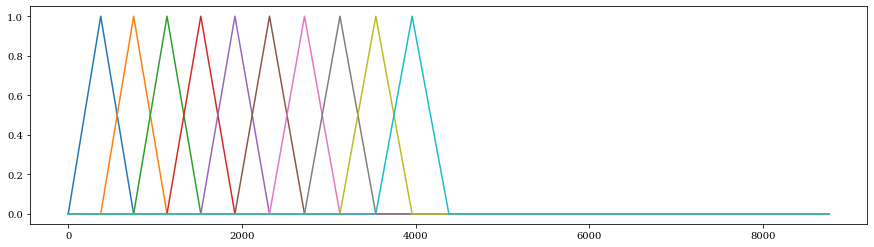

In [68]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [66]:
filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
# for n in range(len(filter_points)-2):
n = 8
filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])

In [64]:
np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1]).shape

filters[n, filter_points[n] : filter_points[n + 1]].shape, np.linspace(0, 1, filter_points[n + 1] - filter_points[n]).shape

np.linspace(0, 1, filter_points[n + 1] - filter_points[n]).shape, filters[n, filter_points[n + 1] : filter_points[n + 2]].shape

((418,), (423,))

But the SNR > 0 indicates that our target signal (CW waves) is present and we need better system to predict them.

### So what about the gaps in the timestamp?

The gaps are becasue the detectors are not turned on 24x7. They need to go into maintainence or something else, and since we have two detectors they might not have readings at the dame time.

Let's see how we can generate SFTs with CW waves with gaps following the tutorials. Note that I am purposefully generating SFT with higher SNR so that it's easy to visualize the CW waves features.

In [75]:
# We can provide different timestamps using a dict with values indicating the name of the detector.
# We are using the timestamp of the H1 detector taken from the first row of the provided csv file.
timestamps = {"H1": data[detector][1]}

# Setup Writer
writer_kwargs = {
    "label": "single_detector_gaps",
    "outdir": "PyFstat_example_data",
    "timestamps": timestamps,
    "sqrtSX": 1e-23,  # Single-sided Amplitude Spectral Density of the noise
    "Tsft": 1800,  # Fourier transform time duration
    "SFTWindowType": "tukey",  # Window function to compute short Fourier transforms
    "SFTWindowBeta": 0.01,  # Parameter associated to the window function
}

# These parameters determine the CW signal that we have to detect.
signal_parameters = {
    "F0": 100.0,
    "F1": -1e-9,
    "Alpha": 0.0,
    "Delta": 0.0,
    "h0": 1e-22,
    "cosi": 1,
    "psi": 0.0,
    "phi": 0.0,
}

writer = pyfstat.Writer(**writer_kwargs, **signal_parameters)
# writer = pyfstat.Writer(**writer_kwargs)

# Create SFTs
writer.make_data()
frequency, timestamps, fourier_data = get_sft_as_arrays(writer.sftfilepath)

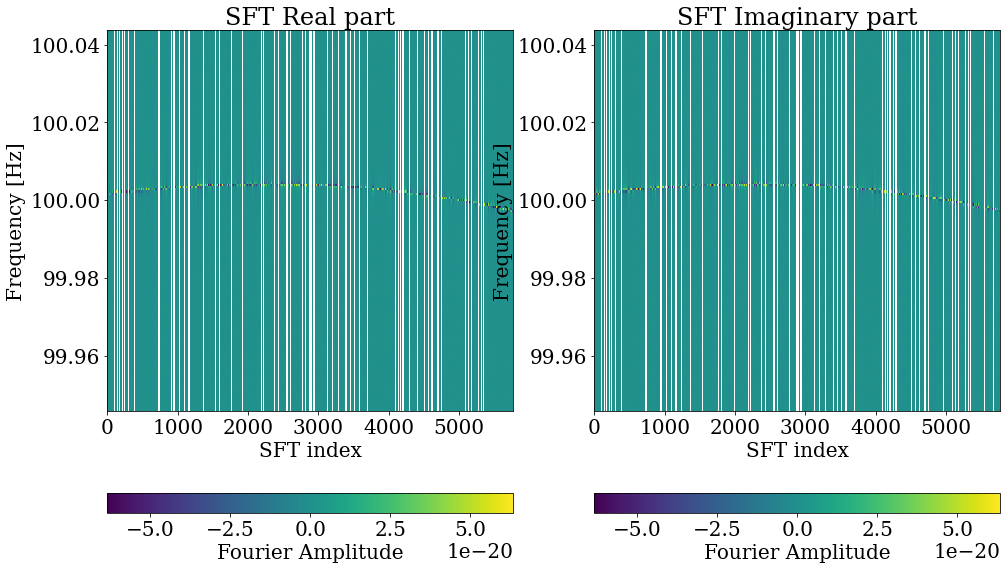

In [76]:
plot_real_imag_spectrograms_with_gaps(
#     timestamps["H1"], frequency, fourier_data["H1"], writer_kwargs["Tsft"]
);

# WIP